<a href="https://colab.research.google.com/github/ko120/FPGA-Design/blob/main/Rock_Paper_Scissors_Classifier_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import statements and boiler plate code (do not change)
import tensorflow_datasets as tfds
import tensorflow as tf 
import tensorflow.keras as ks
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import random 
from typing import *
import sys
from keras.applications import ResNet50
from sklearn.model_selection import train_test_split

Seed = Tuple[int, int]

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

random value:  244
random value:  241


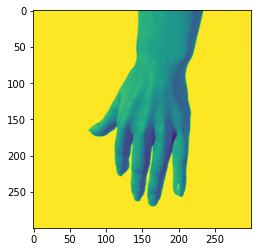

random value:  263


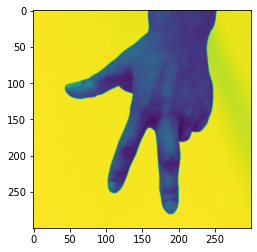

random value:  246


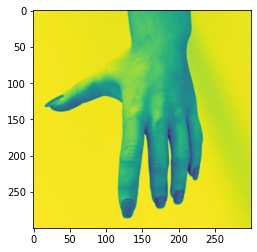

random value:  241


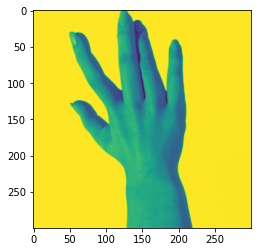

random value:  258


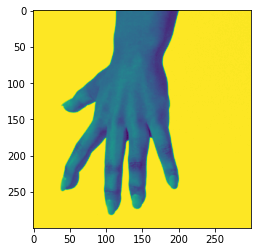

random value:  259


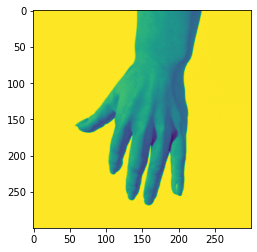

random value:  267


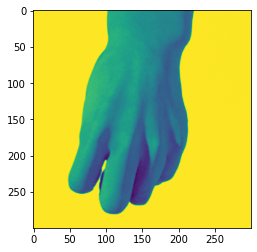

random value:  247


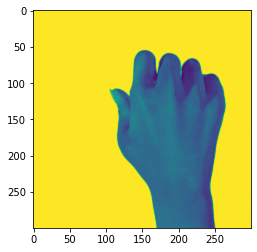

random value:  250


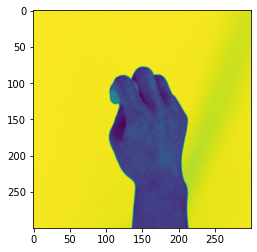

random value:  250


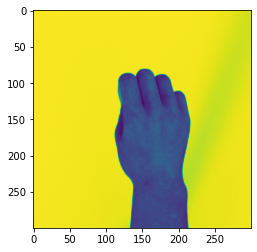

random value:  267


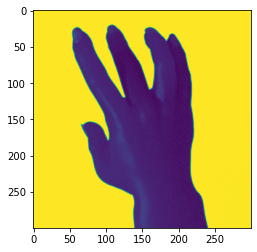

random value:  269


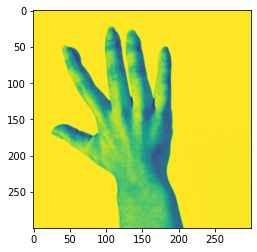

In [ ]:
# QUESTION 2
np_rng = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(10)))

"""Template to use when preprocessing"""
def randint_gen(low = 9, high = 19):
  intval = np_rng.randint(low = low, high = high)
  return intval

rng = tf.random.get_global_generator() # TODO: get global random number generator

def preprocess(image: tf.Tensor, label: tf.Tensor, disp: bool = False):
  seed = rng.make_seeds(count = 1) # TODO: make one seed using rng
  image, label = preprocess_deterministic(image, label, seed[:,0], disp)
  return image, label


def preprocess_deterministic(image: tf.Tensor, label: tf.Tensor, seed: Seed, disp: bool = False):

  image_width, image_height, image_colors = image.shape
  image = tf.cast(image, tf.float32)
  image = image/255.
  randint = tf.cast(tf.random.uniform([], minval=0.8 * image_width, maxval=0.9 * image_width, seed=10), tf.int64)

  if disp:
    tf.print("random value: ", randint)

  
  tf.image.stateless_random_crop(image,size = [randint,randint,3],seed = seed)
  image =  tf.image.resize(image, [image_height, image_width])

  # Hint: look in the TensorFlow API for random image operations. the important thing to note is that you should be using the stateless versions of the operations, not the TensorFlow 1.x versions
  # d. Use generated seed from the TensorFlow random number generator for vii-xii
  
  # 9 Apply a random flip
  image = tf.image.stateless_random_flip_up_down(image, seed = seed)
  # 10 Apply a random hue augmentation, max alpha = 0.3
  image = tf.image.stateless_random_hue(image,0.3, seed = seed )
  # 11 Apply a random brightness augmentation, max alpha = 0.1
  image = tf.image.stateless_random_brightness(image,0.1, seed = seed)
  # 12 Apply a random contrast augmentation, min % change = -10, max % change = 10
  image = tf.image.stateless_random_contrast(image,0.9, 1.1,seed = seed)
  # 13 One-hot encode the label with depth 3 (for rock, paper, and scissors) if using sparse categorical cross entropy in 4
  label = tf.one_hot(label,3)


  return image, label

"""script to load data set and print info"""
(train, test), info = tfds.load("rock_paper_scissors", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
# a Print the dataset info
print(info)

""" Test """

train = train.map(lambda x, y: preprocess(x, y, disp = True)).batch(1)
for i, (image, _) in enumerate(train):
  plt.imshow(image[0, ..., 0])


  plt.show()
  if i > 10:
    break

In [ ]:
# QUESTION 3
#Look up the ResNet Paper and build the core residual learning building block. Do option B given in the paper. (Hint: read the paper)
""" Custom Building Blocks """
class ResidualBlock(ks.layers.Layer):
  def __init__(self, 
               filters: int, 
               dilation_rate: Tuple[int, int] = (1,1), 
               kernel_initializer: str = 'glorot_uniform', 
               momentum: float = 0.99, 
               epsilon: float = 0.001, 
               downsample: bool = False,
               use_bias: bool = False, 
               use_sync: bool = True, 
               kernel_regularizer = None, 
               bias_regularizer = None):
    
    # parameters Conv2D
    self._filters = filters
    self._dilation_rate = dilation_rate
    self._kernel_initializer = kernel_initializer
    self._kernel_regularizer = kernel_regularizer
    self._bias_regularizer = bias_regularizer
    self._use_bias = use_bias
    self._use_sync = use_sync

    # parameters Batch Norm
    if K.image_data_format() == "channels_last":
      # channels_last: (batch_size, height, width, channels)
      self._axis = -1
    else:
      # not channels_last: (batch_size, channels, height, width)
      self._axis = 1

    self._momentum = momentum 
    self._epsilon = epsilon 

    # downsample
    self._downsample = downsample

    if downsample:
      self._strides = (2,2)
    else:
      self._strides = (1,1)

    # TODO: set the activation function to the same one that is used in the paper
    self._activation = tf.keras.activations.relu

    super(ResidualBlock, self).__init__()

  def build(self, ishape):
    # TODO: fill in this function
    if self._downsample:
      self._dsampleconv = ks.layers.Conv2D(self._filters, 
                                           kernel_size = (1,1), 
                                           strides = (2,2), 
                                           padding = "same", 
                                           dilation_rate = self._dilation_rate,
                                           use_bias=self._use_bias,
                                           kernel_initializer = self._kernel_initializer, 
                                           kernel_regularizer = self._kernel_regularizer, 
                                           bias_regularizer = self._bias_regularizer)
      self._dsamplebn = ks.layers.BatchNormalization(axis = self._axis, 
                                                     momentum = self._momentum, 
                                                     epsilon = self._epsilon)

    self._conv1 = ks.layers.Conv2D(self._filters, 
                                   kernel_size = (3,3), 
                                   strides = self._strides, # -> 2 if downsample, 1 if not
                                   padding = "same", 
                                   dilation_rate = self._dilation_rate,
                                   use_bias=self._use_bias,
                                   kernel_initializer = self._kernel_initializer, 
                                   kernel_regularizer = self._kernel_regularizer, 
                                   bias_regularizer = self._bias_regularizer)
    self._bn1 = ks.layers.BatchNormalization(axis = self._axis, 
                                             momentum = self._momentum, 
                                             epsilon = self._epsilon)
    
    self._conv2 = ks.layers.Conv2D(self._filters, 
                                   kernel_size = (3,3), 
                                   strides = (1,1), 
                                   padding = "same", 
                                   dilation_rate = self._dilation_rate,
                                   use_bias=self._use_bias,
                                   kernel_initializer = self._kernel_initializer, 
                                   kernel_regularizer = self._kernel_regularizer, 
                                   bias_regularizer = self._bias_regularizer)
    self._bn2 = ks.layers.BatchNormalization(axis = self._axis, 
                                             momentum = self._momentum, 
                                             epsilon = self._epsilon)

    self._add = ks.layers.Add()

  def call(self, inputs):
    identity = inputs

    out = self._conv1(inputs)
    out = self._bn1(out)
    out = self._activation(out)

    out = self._conv2(out)
    out = self._bn2(out)

    if self._downsample :
      identity = self._dsampleconv(identity)
      identity = self._dsamplebn(identity)
    
    out = self._add([identity,out])
    out = self._activation(out)
    
    return self._activation(out)

"""Testing"""
vis = train.take(10)
for image, t in vis:
  # The input is a (1, 300, 300, 3) tensor. The 1 corresponds to the number of
  # images per batch. The (300, 300) corresponds to the input image size. The
  # 3 stands for the three channels: red, green, and blue
  # https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_images
  # A non-downsampling residual block gives an output with the same shape as
  # the input. Think about why.
  x = ResidualBlock(filters = 3)(image)
  # The output of the below line should be (1, 150, 150, 32) because the input
  # was a (1, 300, 300, 3) tensor. The number of filters becomes the number of
  # channels on the output and the width and height of the tensor gets cut in
  # half by the downsampling convolution.
  y = ResidualBlock(filters = 32, downsample=True)(image)
  print(x.shape, y.shape)

random value:  244
random value:  241
(1, 300, 300, 3) (1, 150, 150, 32)
random value:  263
(1, 300, 300, 3) (1, 150, 150, 32)
random value:  246
(1, 300, 300, 3) (1, 150, 150, 32)
random value:  241
(1, 300, 300, 3) (1, 150, 150, 32)
random value:  258
(1, 300, 300, 3) (1, 150, 150, 32)
random value:  259
(1, 300, 300, 3) (1, 150, 150, 32)
random value:  267
(1, 300, 300, 3) (1, 150, 150, 32)
random value:  247
(1, 300, 300, 3) (1, 150, 150, 32)
random value:  250
(1, 300, 300, 3) (1, 150, 150, 32)
random value:  250
(1, 300, 300, 3) (1, 150, 150, 32)


In [ ]:
# QUESTION 4
# Create a convolutional neural network using the Functional API 
# (define the model as a function instead of using the Sequential class) to classify hand pose images as rock, paper, or scissors. 
# Use a softmax Activation layer as the last layer of the model in order to convert the logits outputted by the CNN into a prediction. (Hint: Use the residual building block that you just made)
def create_model():
  
  input = x = ks.layers.Input((300, 300, 3))
  x = ks.layers.ZeroPadding2D(padding = (3,3))(x)
  x = ks.layers.Conv2D(filters = 64,kernel_size =(7,7), strides= (2,2))(input)
  x = ks.layers.ZeroPadding2D(padding = (1,1))(x)
  x = ks.layers.MaxPooling2D(pool_size = 3, strides =2)(x)
  x = ResidualBlock(filters = 64, downsample= True)(x)
  x = ResidualBlock(filters = 64)(x)
  x = ResidualBlock(filters = 128, downsample= True)(x)
  x = ResidualBlock(filters = 128)(x)
  x = ResidualBlock(filters = 256, downsample= True)(x)
  x = ResidualBlock(filters = 256)(x)
  x = ResidualBlock(filters = 512, downsample= True)(x)
  x = ResidualBlock(filters = 512)(x)
  x = ks.layers.AveragePooling2D(pool_size = 2)(x)
  x = ks.layers.Flatten()(x)
  x = ks.layers.Dropout((0.7))(x)
  x = ks.layers.Dense(units = 1000, activation ="relu")(x)
  x = ks.layers.Dense(units = 512, activation ="relu")(x)
  x = ks.layers.Dense(units = 3, activation ="softmax")(x)
  model = ks.Model(input, x)
  model.build(input_shape=(None, 300, 300, 3))
 
  model.summary()

  return model
  
model = create_model()

"""script to load data set and print info"""
(train, test), info = tfds.load("rock_paper_scissors", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
train = train.map(lambda x, y: preprocess(x, y, disp = False)).batch(40)
test = test.map(lambda x, y: preprocess(x, y, disp = False)).batch(40)

EPOCHS = 5
optimizer = ks.optimizers.Adam()
loss_fn = ks.losses.CategoricalCrossentropy()
metrics_fn = ks.metrics.CategoricalAccuracy()


"""script that will be used to test you model"""
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics_fn)
model.fit(train, validation_data=test, epochs=EPOCHS)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 147, 147, 64)      9472      
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 149, 149, 64)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
residual_block_168 (Residual (None, 37, 37, 64)        78592     
_________________________________________________________________
residual_block_169 (Residual (None, 37, 37, 64)        74240     
_________________________________________________________________
residual_block_170 (Residual (None, 19, 19, 128)       230

In [ ]:
# QUESTION 5
model = create_model() # reinitialize the model from Question 3 without trained weights from .fit(...)

(train, test), info = tfds.load("rock_paper_scissors", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
train = train.map(lambda x, y: preprocess(x, y, disp = False)).batch(40)
test = test.map(lambda x, y: preprocess(x, y, disp = False)).batch(40)

EPOCHS = 15
optimizer = ks.optimizers.Adam(learning_rate= 0.01)
loss_fn = ks.losses.CategoricalCrossentropy()

loss = ks.metrics.Mean()
val_loss = ks.metrics.Mean()
train_acc = ks.metrics.CategoricalAccuracy()
val_acc = ks.metrics.CategoricalAccuracy()



# building a custom training loop 

for epoch in range(EPOCHS):

  print(f"epoch: {epoch}")
  for (image,label) in train:

    with tf.GradientTape() as tape:
      output = model(image, training = True)
      loss_ = loss_fn(label, output)

    grad_train = tape.gradient(loss_, model.trainable_variables)
    optimizer.apply_gradients(zip(grad_train, model.trainable_variables))
    loss(loss_)
    train_acc(label,output)
    
   
  print(f"avg loss :: {loss.result()}, avg accuracy :: {train_acc.result()}", end = "\n")

  
  for (image,label) in test: 

    output = model(image, training = False)
    loss_ = loss_fn(label, output)

    val_acc(label,output)
    val_loss(loss_)
    

  print(f"avg val loss :: {val_loss.result()}, avg val accuracy :: {val_acc.result()}", end = "\n")
  
 ## important to reset at the end
  loss.reset_states()
  train_acc.reset_states()
  val_loss.reset_states()
  val_acc.reset_states()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 147, 147, 64)      9472      
_________________________________________________________________
zero_padding2d_37 (ZeroPaddi (None, 149, 149, 64)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
residual_block_208 (Residual (None, 37, 37, 64)        78592     
_________________________________________________________________
residual_block_209 (Residual (None, 37, 37, 64)        74240     
_________________________________________________________________
residual_block_210 (Residual (None, 19, 19, 128)       230

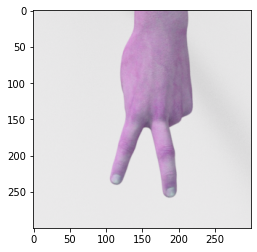

scissors scissors


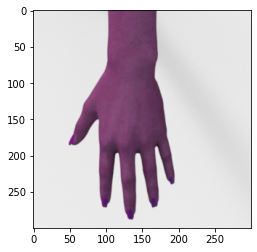

paper paper


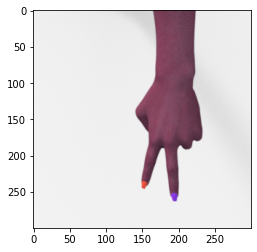

scissors scissors


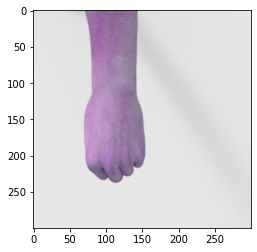

rock rock


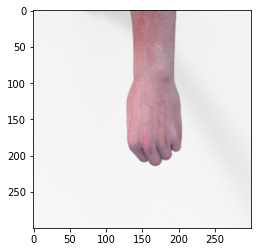

rock rock


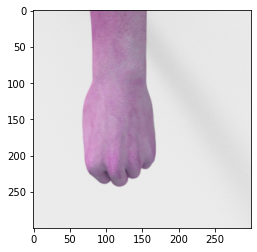

rock rock


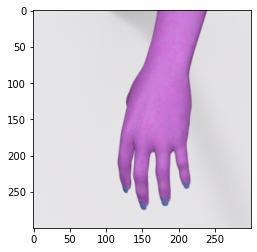

scissors paper


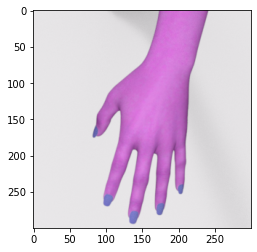

paper paper


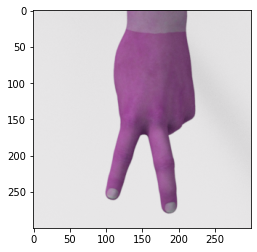

scissors scissors


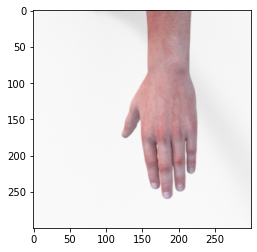

rock paper


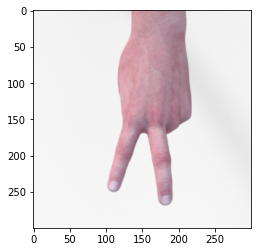

scissors scissors


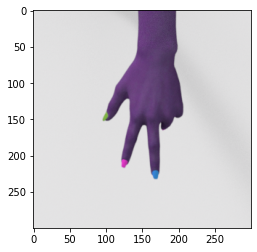

scissors scissors


In [ ]:
# TESTING FOR QUESTION 5
"""visualize/ test the trained model"""
(train, test), info = tfds.load("rock_paper_scissors", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
test = test.map(lambda x, y: preprocess(x, y, disp = False)).batch(1)

class_dict = {0:"rock", 1:"paper", 2:"scissors"}
for i, (image, label) in enumerate(test):
  classif = model(image)
  if (tf.shape(image)[-1] != 3):
    plt.imshow(image[0, ..., 0])
  else:
    plt.imshow(image[0, ...])
  plt.show()
  print(class_dict[int(tf.math.argmax(classif, axis = -1)[0])], class_dict[int(tf.math.argmax(label, axis = -1)[0])])

  if i > 10:
    break